In [85]:
import random
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import socket
import time

In [97]:
class inhomogenousMarkovChain:
    def __init__(self, order):
        self.order = order
        self.trans = defaultdict(lambda: defaultdict(int))
        self.start = defaultdict(int)

    def add_sequence(self, sequence):
        order = self.order
        for i in range(len(sequence) - order):
            state = tuple(sequence[i:i+order])
            next_note = sequence[i+order]
            self.trans[state][next_note] += 1
            if i == 0:
                self.start[state] += 1

    def generate_sequence(self, length, start_state=None):
        current_state = start_state if start_state else self.choose_start_state()
        sequence = list(current_state)
        for _ in range(length - len(current_state)):
            next_note = self.choose_next_note(current_state)
            sequence.append(next_note)
            current_state = tuple(sequence[-self.order:])
        return sequence, tuple(sequence[-self.order:])

    def choose_start_state(self):
        total = sum(self.start.values())
        # random.choices doesn't like defaultdict
        r = random.uniform(0, total)
        for state, count in self.start.items():
            r -= count
            if r <= 0:
                return state
    
    def choose_next_note(self, state):
        order = self.order
        sub_state = state[-order:]
        if sub_state in self.trans:
            total = sum(self.trans[sub_state].values())
            # random.choices doesn't like defaultdict
            r = random.uniform(0, total)
            for note, count in self.trans[sub_state].items():
                r -= count
                if r <= 0:
                    return note
        return random.choice(list(self.trans.keys())[0])
    
    

In [87]:
input_sequence = []
with open('..\\sources\\comb.txt', 'r') as file:
    input_sequence = file.read().split('","')
print(input_sequence)

['N0', 'R1', 'N0', 'R1', 'G1', 'N0', 'R1', 'N0', 'G1', 'R1', 'G1', 'N0', 'M1', 'G1', 'R1', 'S1', 'N0', 'R1', 'G1', 'M1', 'R1', 'G1', 'M1', 'P1', 'M1', 'D1', 'P1', 'M1', 'D1', 'N1', 'M1', 'D1', 'M1', 'N1', 'G1', 'M1', 'G1', 'N1', 'D1', 'P1', 'M1', 'R1', 'G1', 'N0', 'R1', 'S1', 'D0', 'N0', 'D0', 'S1', 'D0', 'N0', 'R1', 'G1', 'N0', 'R1', 'G1', 'G1', 'R1', 'G1', 'N0', 'R1', 'N0', 'G1', 'N0', 'R1', 'G1', 'M1', 'R1', 'M1', 'G1', 'G1', 'R1', 'M1', 'G1', 'M1', 'P1', 'G1', 'M1', 'P1', 'R1', 'S1', 'N0', 'R1', 'S1', 'N0', 'R1', 'G1', 'M1', 'P1', 'M1', 'P1', 'M1', 'P1', 'P1', 'M1', 'D1', 'P1', 'M1', 'P1', 'M1', 'D1', 'M1', 'N1', 'N1', 'D1', 'P1', 'M1', 'G1', 'G1', 'M1', 'D1', 'N1', 'M1', 'D1', 'N1', 'N1', 'D1', 'P1', 'M1', 'G1', 'R1', 'S1', 'N0', 'R1', 'S1', 'N0', 'R1', 'G1', 'N0', 'R1', 'M1', 'G1', 'M1', 'P1', 'M1', 'D1', 'P1', 'N1', 'D1', 'P1', 'M1', 'R1', 'G1', 'R1', 'N0', 'R1', 'D0', 'N0', 'S1', 'N0', 'R1', 'S1', 'N1', 'R1', 'G1', 'M1', 'P1', 'D1', 'N1', 'S2', 'S2', 'N1', 'D1', 'P1', 'M1', 'G1

In [100]:
markov_chain = inhomogenousMarkovChain(order = 3)
markov_chain.add_sequence(input_sequence)
t = None
for i in range(5):
    generated_sequence,t = markov_chain.generate_sequence(20, t)
    print((generated_sequence))

['N0', 'R1', 'N0', 'G1', 'R1', 'G1', 'N0', 'R1', 'S1', 'N0', 'R1', 'G1', 'M1', 'D1', 'N1', 'M1', 'D1', 'M1', 'N1', 'N1']
['M1', 'N1', 'N1', 'D1', 'P1', 'M1', 'G1', 'G1', 'M1', 'D1', 'N1', 'R2', 'G2', 'R2', 'S2', 'N1', 'D1', 'P1', 'M1', 'G1']
['P1', 'M1', 'G1', 'R1', 'N0', 'R1', 'G1', 'N0', 'R1', 'G1', 'N0', 'M1', 'G1', 'R1', 'S1', 'N0', 'R1', 'G1', 'M1', 'P1']
['G1', 'M1', 'P1', 'D1', 'N1', 'S2', 'S2', 'N1', 'D1', 'P1', 'M1', 'D1', 'P1', 'M1', 'P1', 'M1', 'P1', 'M1', 'D1', 'N1']
['M1', 'D1', 'N1', 'R2', 'G2', 'R2', 'S2', 'N1', 'D1', 'P1', 'M1', 'R1', 'G1', 'N0', 'R1', 'M1', 'G1', 'M1', 'G1', 'G1']


In [89]:
def visualize_transitions(inhomogenousMarkovChain, top_n_transitions=2):
        chain = inhomogenousMarkovChain
        order = chain.order
        G = nx.DiGraph()
        for state, transitions in chain.trans.items():
            if len(state) == order:
                state_str = ''.join(state)
                total = sum(transitions.values())
                top_transitions = sorted(transitions.items(), key=lambda x: x[1], reverse=True)[:top_n_transitions]
                
                for next_note, count in top_transitions:
                    probability = count / total
                    next_state = state[1:] + (next_note,)
                    next_state_str = ''.join(next_state)
                    
                    G.add_edge(state_str, next_state_str, weight=probability, order=order)
        
        pos = nx.spring_layout(G, k=0.9, iterations=50)
        
        plt.figure(figsize=(12, 8))
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500, alpha=0.8)
        
        # Draw edges
        edges = G.edges()
        weights = [G[u][v]['weight'] for u, v in edges]
        nx.draw_networkx_edges(G, pos, edge_color='gray', width=[w * 5 for w in weights], arrows=True, arrowsize=20)
        
        # Draw labels
        nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
        
        # Draw edge labels
        edge_labels = nx.get_edge_attributes(G, 'weight')
        edge_labels = {k: f'{v:.2f}' for k, v in edge_labels.items()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
        
        plt.title(f"Markov Chain Transition Probabilities - {chain.order} order, top {top_n_transitions} transitions")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

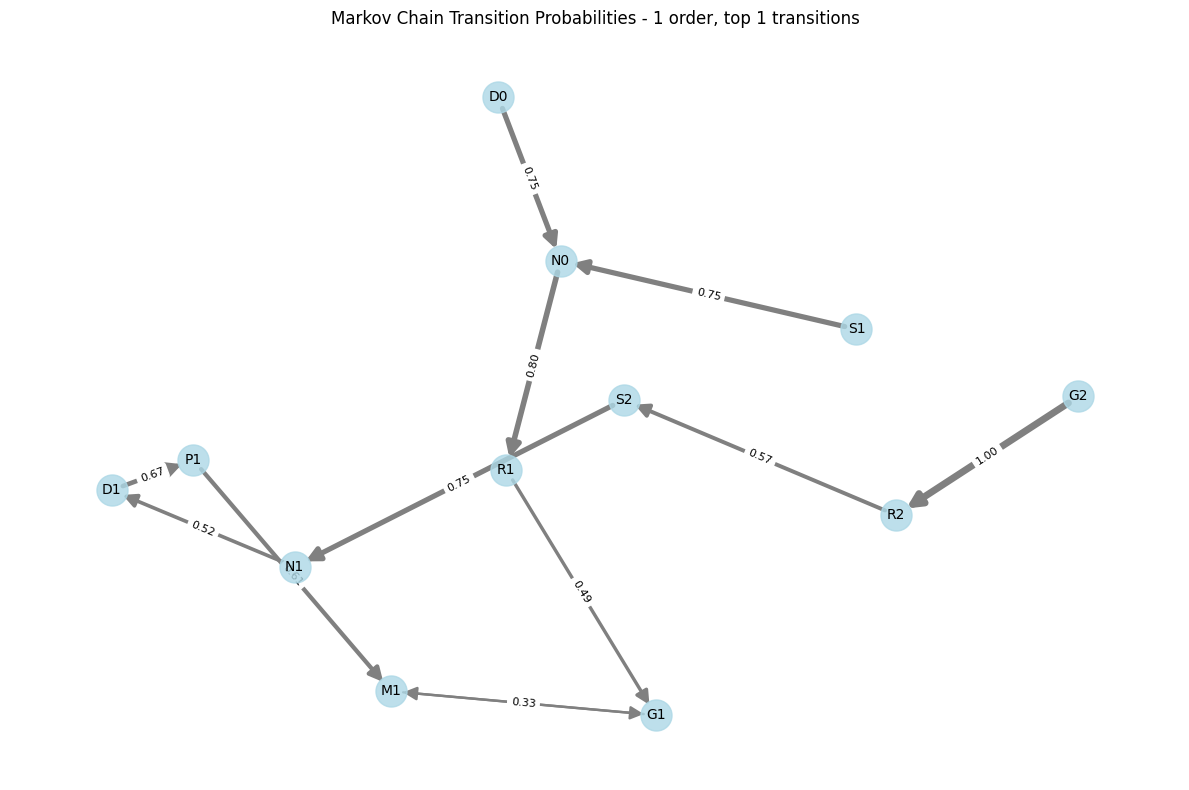

In [90]:
visualize_transitions(markov_chain,top_n_transitions=1)

In [91]:
UDP_IP = "127.0.0.1"
UDP_PORT = 3333
print("UDP target IP: %s" % UDP_IP)
print("UDP target port: %s" % UDP_PORT)
sock = socket.socket(socket.AF_INET,
                     socket.SOCK_DGRAM)

UDP target IP: 127.0.0.1
UDP target port: 3333


In [95]:
d = {'D0': 7,
 'N0': 9,
 'S1': 12,
 'R1': 14,
 'G1': 16,
 'M1': 18,
 'P1': 19,
 'D1': 21,
 'N1': 23,
 'S2': 24,
 'R2': 26,
 'G2': 28}
markov_chain = inhomogenousMarkovChain(order = 1)
markov_chain.add_sequence(input_sequence)
generated_sequence = markov_chain.generate_sequence(20)
ntomidi = [d[i] + 48 for i in generated_sequence]
ntomidi

[57,
 62,
 57,
 62,
 64,
 66,
 64,
 66,
 69,
 67,
 66,
 71,
 66,
 64,
 57,
 64,
 66,
 69,
 71,
 74]

In [96]:
pause=.4
for i in ntomidi:
    sock.sendto(i.to_bytes(8, byteorder="big"), (UDP_IP, UDP_PORT))
    print("sent:     ", i)
    time.sleep (pause)

sent:      57
sent:      62
sent:      57
sent:      62
sent:      64
sent:      66
sent:      64
sent:      66
sent:      69
sent:      67
sent:      66
sent:      71
sent:      66
sent:      64
sent:      57
sent:      64
sent:      66
sent:      69
sent:      71
sent:      74
